Mount the drive to import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import all libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

Extract the zip file of dataset

In [ ]:
import os
import zipfile

zip_file_name = '/content/drive/MyDrive/pdl_dataset/MITWPU_CAPTION.zip'
extract_path = '/content/MITWPU_CAPTION'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
"""
# List all contents in the extracted folder
for root, dirs, files in os.walk(extract_path):
    for name in dirs:
        print("Directory:", os.path.join(root, name))
    for name in files:
        print("File:", os.path.join(root, name))
"""

'\n# List all contents in the extracted folder\nfor root, dirs, files in os.walk(extract_path):\n    for name in dirs:\n        print("Directory:", os.path.join(root, name))\n    for name in files:\n        print("File:", os.path.join(root, name))\n'

In [ ]:
#used to make few changes to the dataset

"""input_file = '/content/MITWPU_CAPTION/mitcaption.csv'         # Replace with your actual file path
output_file = '/content/MITWPU_CAPTION/mitcaption_for_code.csv'       # Output file with corrected format

with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    header = infile.readline()
    outfile.write(header)  # write header as is

    for line in infile:
        line = line.strip()
        if not line:
            outfile.write('\n')  # keep empty lines
            continue

        # Try to split into image and caption
        parts = line.split(',', 1)  # only split on first comma

        if len(parts) == 2:
            image, caption = parts
            caption = caption.strip()

            # Add quotes around caption if missing
            if not (caption.startswith('"') and caption.endswith('"')):
                caption = f'"{caption}"'

            outfile.write(f'{image},{caption}\n')
        else:
            # Line doesn't have two parts—write it back untouched
            outfile.write(f'{line}\n')"""

'input_file = \'/content/MITWPU_CAPTION/mitcaption.csv\'         # Replace with your actual file path\noutput_file = \'/content/MITWPU_CAPTION/mitcaption_for_code.csv\'       # Output file with corrected format\n\nwith open(input_file, \'r\') as infile, open(output_file, \'w\') as outfile:\n    header = infile.readline()\n    outfile.write(header)  # write header as is\n\n    for line in infile:\n        line = line.strip()\n        if not line:\n            outfile.write(\'\n\')  # keep empty lines\n            continue\n\n        # Try to split into image and caption\n        parts = line.split(\',\', 1)  # only split on first comma\n\n        if len(parts) == 2:\n            image, caption = parts\n            caption = caption.strip()\n\n            # Add quotes around caption if missing\n            if not (caption.startswith(\'"\') and caption.endswith(\'"\')):\n                caption = f\'"{caption}"\'\n\n            outfile.write(f\'{image},{caption}\n\')\n        else:\n     

Import the csv file of captions into data and path of the images

In [ ]:
image_path = '/content/MITWPU_CAPTION/MITWPU_CAPTION/images'
data = pd.read_csv("/content/MITWPU_CAPTION/MITWPU_CAPTION/mitcaption_for_code.csv", on_bad_lines='skip')
data.head()

,image,caption
0,image1.jpg,A robotics lab in a gray brick building with s...
1,image1.jpg,"The MIT-WPU Robocon Robotics Innovation Lab, a..."
2,image1.jpg,A gray brick building houses the Mahaveer MIT-...
3,image1.jpg,Scooters line the exterior of the Mahaveer bui...
4,image1.jpg,The robotics lab stands in a gray brick buildi...


Display the dataset

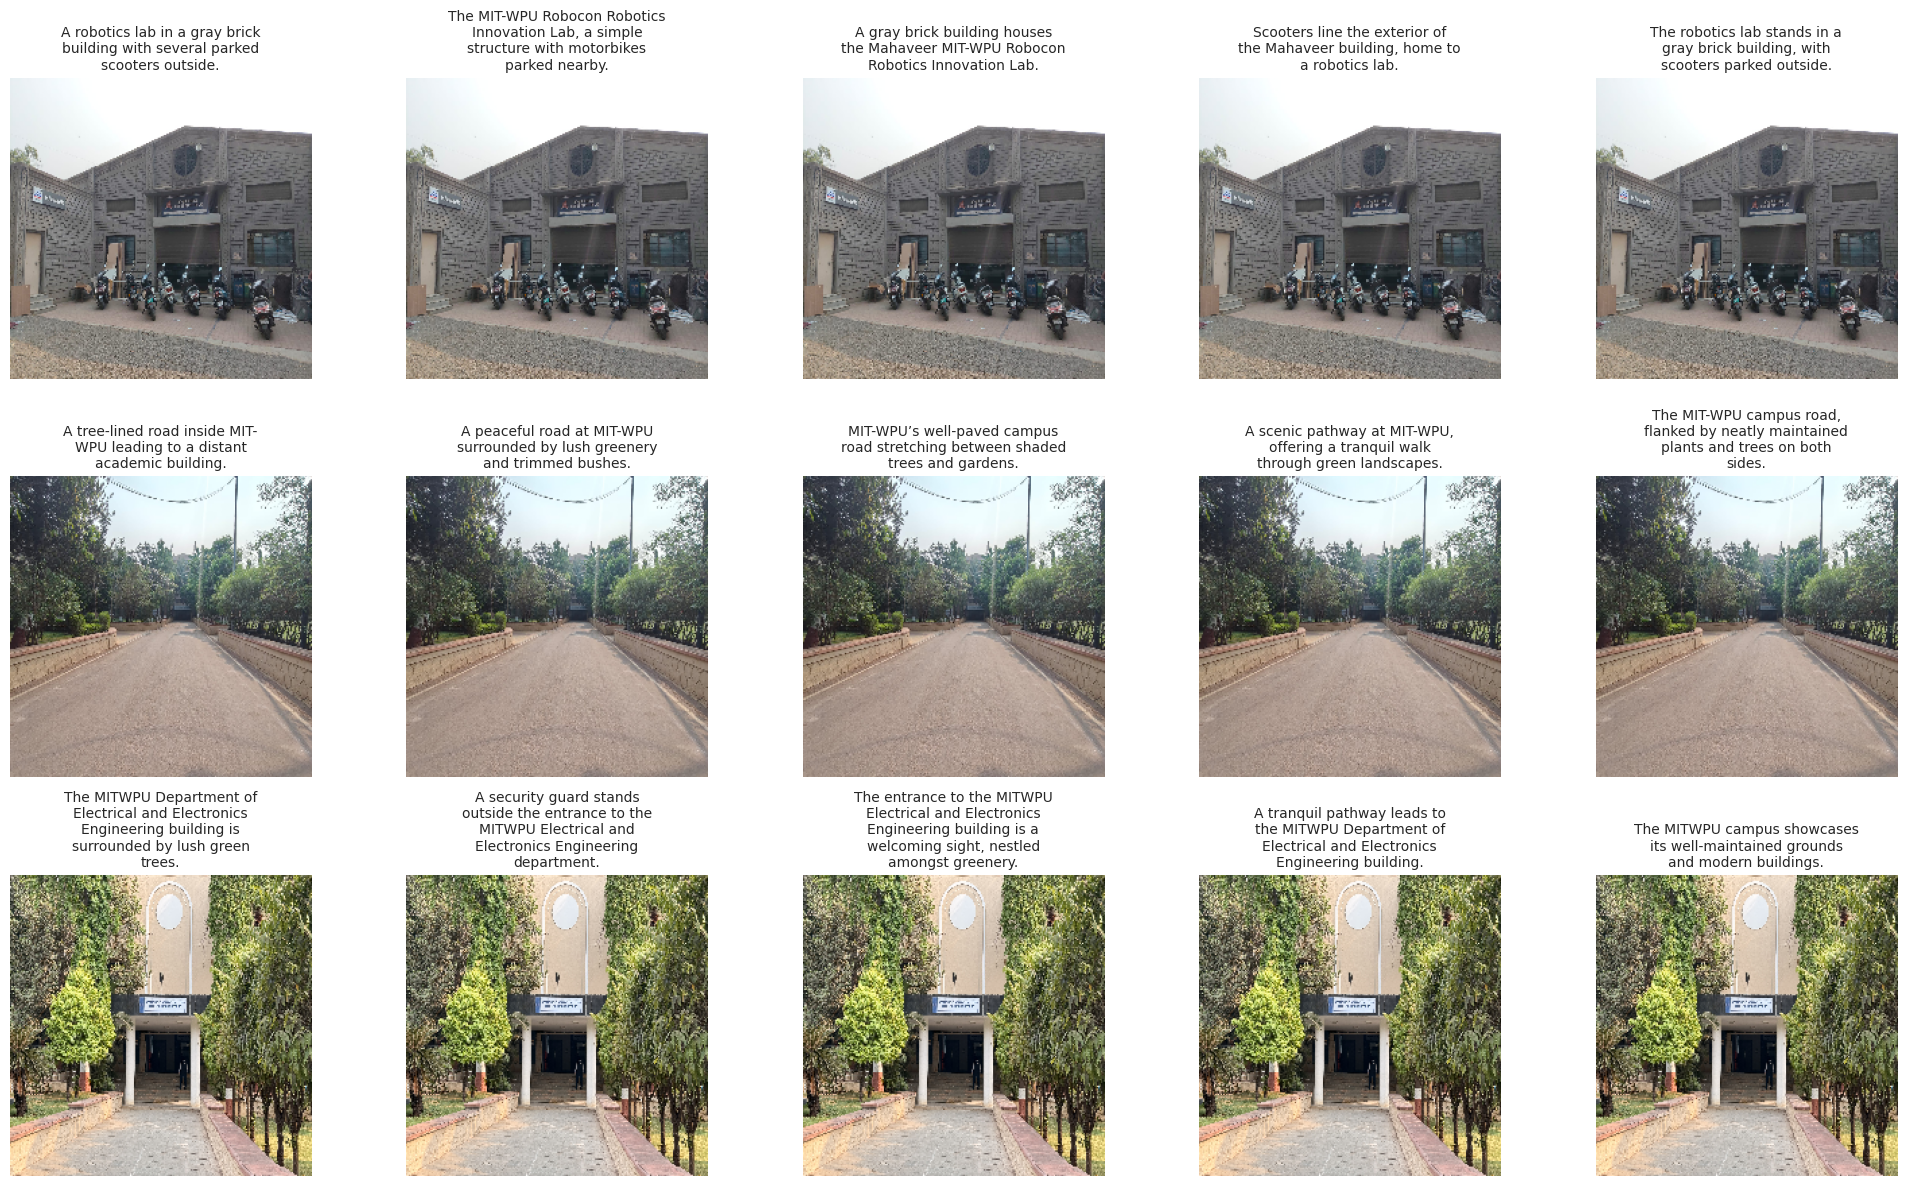

In [ ]:
import os
import matplotlib.pyplot as plt
from textwrap import wrap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def display_images(temp_df):
    # Map lowercase image filenames to actual ones (to avoid case issues)
    image_folder = './MITWPU_CAPTION/MITWPU_CAPTION/images'
    image_files = {f.lower(): f for f in os.listdir(image_folder)}

    # Group captions by image
    grouped = temp_df.groupby('image')['caption'].apply(list).reset_index()
    grouped = grouped.head(3)  # Take only first 3 images

    plt.figure(figsize=(20, 12))

    img_index = 0
    for row in range(3):  # 3 images
        image_filename = grouped.image[row]
        captions = grouped.caption[row]

        actual_file = image_files.get(image_filename.lower())
        if actual_file:
            image_path = os.path.join(image_folder, actual_file)
            image = readImage(image_path)

            for col in range(5):  # 5 captions
                plt.subplot(3, 5, row * 5 + col + 1)
                plt.imshow(image)

                cap = captions[col] if col < len(captions) else "No caption"
                cap_wrapped = "\n".join(wrap(cap, 30))

                plt.title(cap_wrapped, fontsize=10)
                plt.axis("off")
        else:
            for col in range(5):
                plt.subplot(3, 5, row * 5 + col + 1)
                plt.imshow([[1]])
                plt.title(f"Image not found:\n{image_filename}", fontsize=8)
                plt.axis("off")

    plt.tight_layout()
    plt.show()

def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    return img

display_images(data)

Preprocess the captions

In [ ]:
import re

def text_preprocessing(data):
    # Drop rows with missing captions
    data = data.dropna(subset=['caption'])

    # Apply cleaning
    data['caption'] = data['caption'].astype(str).apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"[^a-z ]", "", x))  # keep letters and spaces
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"\s+", " ", x))  # remove extra spaces
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = "startseq " + data['caption'] + " endseq"

    return data


Display the preprocessed captions

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]


['startseq robotics lab in gray brick building with several parked scooters outside endseq',
 'startseq the mitwpu robocon robotics innovation lab simple structure with motorbikes parked nearby endseq',
 'startseq gray brick building houses the mahaveer mitwpu robocon robotics innovation lab endseq',
 'startseq scooters line the exterior of the mahaveer building home to robotics lab endseq',
 'startseq the robotics lab stands in gray brick building with scooters parked outside endseq',
 'startseq grand stone steps lead to buildings entrance framed by elegant columns endseq',
 'startseq wide staircase ascends to glassdoor entrance flanked by tall pillars endseq',
 'startseq the buildings entrance boasts majestic stairway and classic columns endseq',
 'startseq impressive stone steps and pillars create stately entrance to the building endseq',
 'startseq the elegant entrance features broad stairway and towering columns endseq']

tokenize all the captions

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 3, 4, 384, 244, 296, 80, 694, 168, 6, 695, 58, 222, 2]

Extract the features from the images using DensNet201

In [ ]:
import pickle
image_path = './MITWPU_CAPTION/MITWPU_CAPTION/images'
image_files = {f.lower(): f for f in os.listdir(image_path)}

# Load DenseNet201 and extract features
base_model = DenseNet201(weights='imagenet', include_top=True)
fe = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)


img_size = 224
features = {}
valid_images = []  # <-- Track valid images

for image in tqdm(data['image'].unique().tolist()):
    actual_file = image_files.get(image.lower())
    if actual_file:
        full_path = os.path.join(image_path, actual_file)
        try:
            img = load_img(full_path, target_size=(img_size, img_size))
            img = img_to_array(img) / 255.
            img = np.expand_dims(img, axis=0)
            feature = fe.predict(img, verbose=0)
            features[image.lower()] = feature  # Store with lowercase key
            valid_images.append(image)         # <-- Keep only valid images
        except Exception as e:
            print(f"Error processing image {image}: {e}")
    else:
        print(f"Image not found: {image}")


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


 90%|████████▉ | 207/231 [01:40<00:03,  6.87it/s]

Image not found: image220.jpg


100%|██████████| 231/231 [01:41<00:00,  2.27it/s]

Image not found: image236.jpg: A beautifully designed library with a circular atrium
Image not found: image240.jpg: A golden bull statue displayed on a blue-tiled pedestal
Image not found: image241.jpg
Image not found: image242.jpg
Image not found: image243.jpg
Image not found: image244.jpg
Image not found: image245.jpg
Image not found: image246.jpg
Image not found: image247.jpg
Image not found: image248.jpg
Image not found: image249.jpg
Image not found: image250.jpg


Store features into pkl file

In [ ]:
import pickle

# Save the features dictionary to a file
with open('image_features.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Features saved to image_features.pkl")


Features saved to image_features.pkl


In [ ]:
with open('image_features.pkl', 'rb') as f:
    features = pickle.load(f)

Reset the model just incase needed

In [ ]:
import gc
from tensorflow.keras import backend as K

# Clear previous model from memory (if any)
K.clear_session()
gc.collect()


0

# Model

Make the dataset ready to train the model

In [ ]:
class ImprovedDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        # Select batch indices
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        X1, X2, y = self._generate_data(indices)
        return (np.array(X1), np.array(X2)), np.array(y)

    def _generate_data(self, indices):
        X1, X2, y = [], [], []

        for i in indices:
            row = self.df.iloc[i]
            image = row[self.X_col]
            caption = row[self.y_col]

            # Check if image features exist
            if image.lower() not in self.features:
                continue

            # Get image features with slight noise for regularization
            feature = self.features[image.lower()][0]
            if np.random.random() < 0.3:  # 30% chance to add noise
                noise = np.random.normal(0, 0.01, feature.shape)
                feature = feature + noise

            # Process caption
            seq = self.tokenizer.texts_to_sequences([caption])[0]

            # Create input-output pairs
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        return X1, X2, y

train_generator = ImprovedDataGenerator(train, 'image', 'caption', batch_size=32,
                                     tokenizer=tokenizer, vocab_size=vocab_size,
                                     max_length=max_length, features=features)

validation_generator = ImprovedDataGenerator(test, 'image', 'caption', batch_size=32,
                                          tokenizer=tokenizer, vocab_size=vocab_size,
                                          max_length=max_length, features=features)

define the model and start the training process

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Bidirectional

# Input definition
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

# Image feature processing
img_features = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(input1)
img_features = BatchNormalization()(img_features)

img_features = Dropout(0.3)(img_features)
img_features_reshaped = Reshape((1, 512))(img_features)

# Text processing - UPDATED to match image feature dimensions
sentence_features = Embedding(vocab_size, 512, mask_zero=False)(input2)
sentence_features = Dropout(0.3)(sentence_features)

# Merge features - now both have 512 feature dimensions
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# Bidirectional LSTM
sentence_features = Bidirectional(LSTM(256, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))(merged)
x = BatchNormalization()(sentence_features)
x = Dropout(0.5)(x)

x = add([x, img_features])
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
optimizer = Adam(learning_rate=0.0003)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=7,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,  # Less aggressive reduction
    min_lr=1e-8c
)

# Training with class weights if needed
history = caption_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction],
    verbose=1
)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.0015 - loss: 8.7297
Epoch 1: val_loss improved from inf to 8.42925, saving model to model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - accuracy: 0.0015 - loss: 8.7274 - val_accuracy: 0.0056 - val_loss: 8.4292 - learning_rate: 3.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.0043 - loss: 8.4547
Epoch 2: val_loss improved from 8.42925 to 8.29053, saving model to model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.0044 - loss: 8.4526 - val_accuracy: 0.0081 - val_loss: 8.2905 - learning_rate: 3.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.0260 - loss: 8.2076
Epoch 3: val_loss improved from 8.29053 to 8.19250, saving model to model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.0263 - loss: 8.2054 - val_accuracy: 0.0075 - val_loss: 8.1925 - learning_rate: 3.0000e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.0627

display the loss

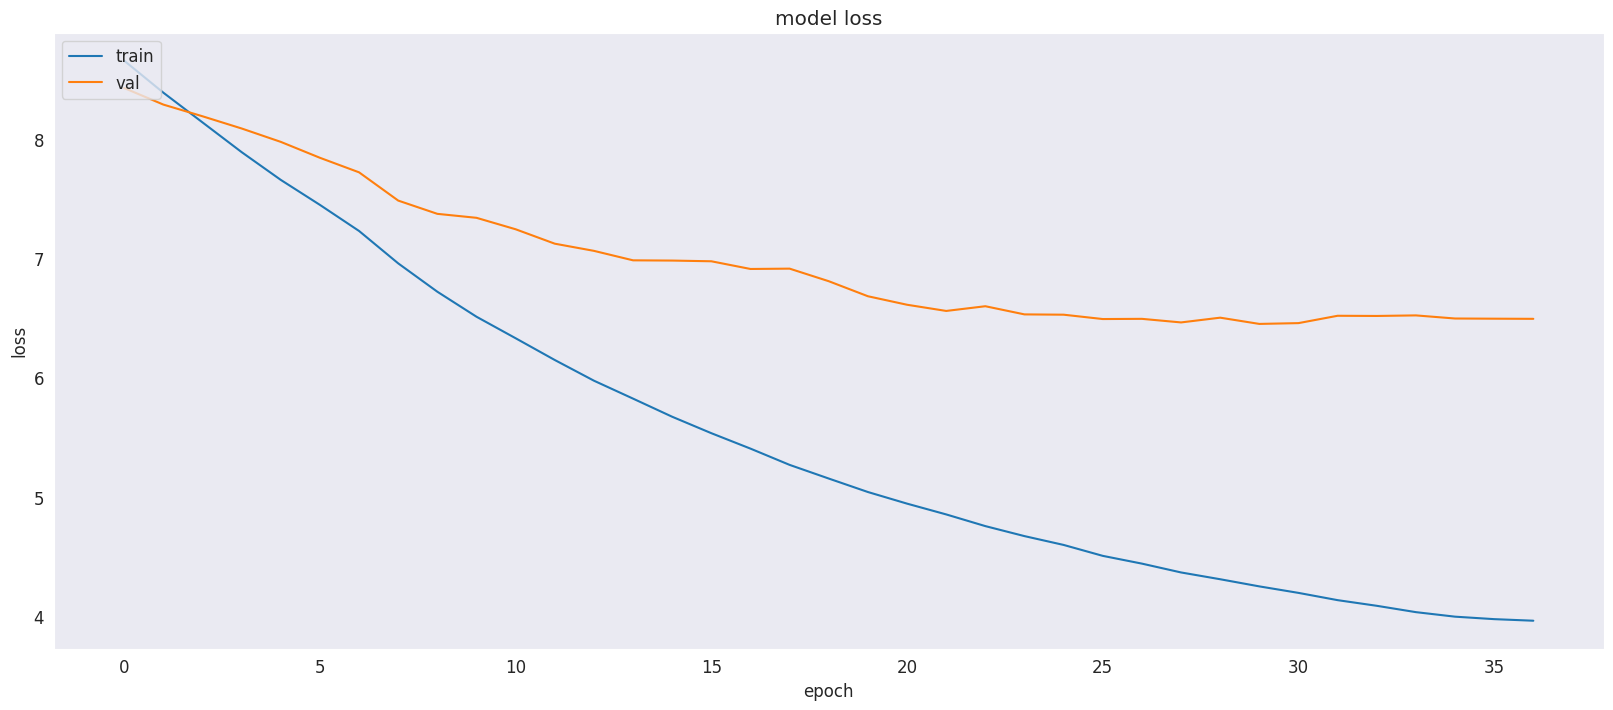

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Store all neccessary files of the model

In [ ]:
import pickle

# Save tokenizer and max_length together
with open("tokenizer.pkl", "wb") as f:
    pickle.dump({"tokenizer": tokenizer, "max_length": max_length}, f)

# Save the feature extractor
fe.save("feature_extractor.keras")


Test the model on unseen image test1

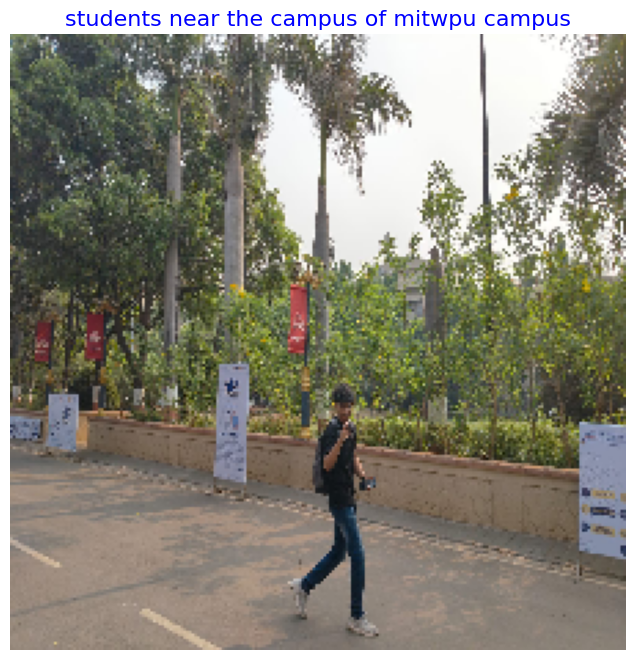

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, img_size=224):
    # Load the trained captioning model and feature extractor
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    # Load tokenizer and max_length
    with open(tokenizer_path, "rb") as f:
        data = pickle.load(f)
        tokenizer = data["tokenizer"]
        max_length = data["max_length"]

    # Preprocess image
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract image features
    image_features = feature_extractor.predict(img_array, verbose=0)

    # Generate caption
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break

    # Clean up caption
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with caption
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

# 🔍 Example usage
image_path = "/content/test2.jpg"  # <-- Update with actual path
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)


Test the model on unseen image test2

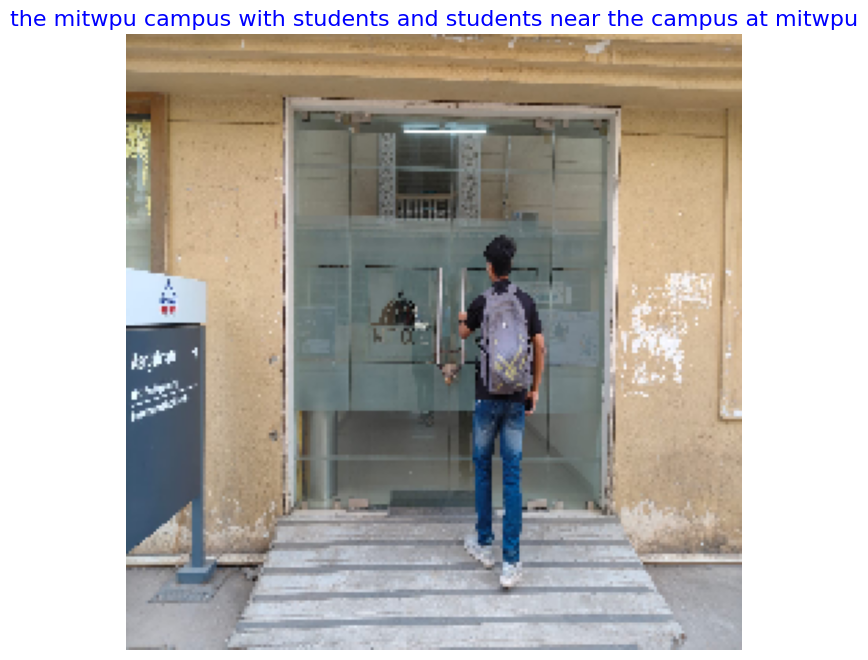

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, img_size=224):
    # Load the trained captioning model and feature extractor
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    # Load tokenizer and max_length
    with open(tokenizer_path, "rb") as f:
        data = pickle.load(f)
        tokenizer = data["tokenizer"]
        max_length = data["max_length"]

    # Preprocess image
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract image features
    image_features = feature_extractor.predict(img_array, verbose=0)

    # Generate caption
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break

    # Clean up caption
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with caption
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

# 🔍 Example usage
image_path = "/content/test1.jpg"  # <-- Update with actual path
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)
